In [104]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
import numpy as np
from typing import Optional

In [105]:
def drop_path_f(x, drop_prob: float = 0., training: bool = False):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path_f(x, self.drop_prob, self.training)


def window_partition(x, window_size: int):
    """
    将feature map按照window_size划分成一个个没有重叠的window
    Args:
        x: (B, H, W, C)
        window_size (int): window size(M)
    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    # permute: [B, H//Mh, Mh, W//Mw, Mw, C] -> [B, H//Mh, W//Mh, Mw, Mw, C]
    # view: [B, H//Mh, W//Mw, Mh, Mw, C] -> [B*num_windows, Mh, Mw, C]
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size: int, H: int, W: int):
    """
    将一个个window还原成一个feature map
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size(M)
        H (int): Height of image
        W (int): Width of image
    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    # view: [B*num_windows, Mh, Mw, C] -> [B, H//Mh, W//Mw, Mh, Mw, C]
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    # permute: [B, H//Mh, W//Mw, Mh, Mw, C] -> [B, H//Mh, Mh, W//Mw, Mw, C]
    # view: [B, H//Mh, Mh, W//Mw, Mw, C] -> [B, H, W, C]
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x

In [106]:
y1 = torch.ones((1,224,224,3))
print(y1.shape)
y2 = window_partition(y1,window_size=7)
print(y2.shape)
y3 = window_reverse(y2,window_size=7,H=224,W=224)
print(y3.shape)

torch.Size([1, 224, 224, 3])
torch.Size([1024, 7, 7, 3])
torch.Size([1, 224, 224, 3])


In [107]:
class PatchEmbed(nn.Module):
    """
    2D Image to Patch Embedding
    """
    def __init__(self, patch_size=4, in_c=3, embed_dim=96, norm_layer=None):
        super().__init__()
        patch_size = (patch_size, patch_size)
        self.patch_size = patch_size
        self.in_chans = in_c
        self.embed_dim = embed_dim
        self.proj = nn.Conv2d(in_c, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        _, _, H, W = x.shape

        # padding
        # 如果输入图片的H，W不是patch_size的整数倍，需要进行padding
        pad_input = (H % self.patch_size[0] != 0) or (W % self.patch_size[1] != 0)
        if pad_input:
            # to pad the last 3 dimensions,
            # (W_left, W_right, H_top,H_bottom, C_front, C_back)
            x = F.pad(x, (0, self.patch_size[1] - W % self.patch_size[1],
                          0, self.patch_size[0] - H % self.patch_size[0],
                          0, 0))

        # 下采样patch_size倍
        x = self.proj(x)
        print("PatchEmbed.....初步卷积后的数据shape为：",x.shape)
        _, _, H, W = x.shape
        # flatten: [B, C, H, W] -> [B, C, HW]
        # transpose: [B, C, HW] -> [B, HW, C]
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)
        return x, H, W

In [108]:
y1 = torch.ones((1,3,224,224))
print(y1.shape)
net = PatchEmbed()
y2,H12,W12 = net(y1)
print(y2.shape)
print(H12)
print(W12)

torch.Size([1, 3, 224, 224])
PatchEmbed.....初步卷积后的数据shape为： torch.Size([1, 96, 56, 56])
torch.Size([1, 3136, 96])
56
56


In [109]:
class PatchMerging(nn.Module):
    r""" Patch Merging Layer.
    Args:
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x, H, W):
        """
        x: B, H*W, C
        """
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        x = x.view(B, H, W, C)

        # padding
        # 如果输入feature map的H，W不是2的整数倍，需要进行padding
        pad_input = (H % 2 == 1) or (W % 2 == 1)
        if pad_input:
            # to pad the last 3 dimensions, starting from the last dimension and moving forward.
            # (C_front, C_back, W_left, W_right, H_top, H_bottom)
            # 注意这里的Tensor通道是[B, H, W, C]，所以会和官方文档有些不同
            x = F.pad(x, (0, 0, 0, W % 2, 0, H % 2))

        x0 = x[:, 0::2, 0::2, :]  # [B, H/2, W/2, C]
        x1 = x[:, 1::2, 0::2, :]  # [B, H/2, W/2, C]
        x2 = x[:, 0::2, 1::2, :]  # [B, H/2, W/2, C]
        x3 = x[:, 1::2, 1::2, :]  # [B, H/2, W/2, C]
        x = torch.cat([x0, x1, x2, x3], -1)  # [B, H/2, W/2, 4*C]
        x = x.view(B, -1, 4 * C)  # [B, H/2*W/2, 4*C]

        x = self.norm(x)
        x = self.reduction(x)  # [B, H/2*W/2, 2*C]

        return x


In [110]:
y1 = torch.ones((1, 3136, 96))
print(y1.shape)
net = PatchMerging(dim=96)
y2 = net(y1,H=56,W=56)
print(y2.shape)

torch.Size([1, 3136, 96])
torch.Size([1, 784, 192])


In [111]:
class Mlp(nn.Module):
    """ MLP as used in Vision Transformer, MLP-Mixer and related networks
    """
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features

        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.drop1 = nn.Dropout(drop)
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop2 = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return x

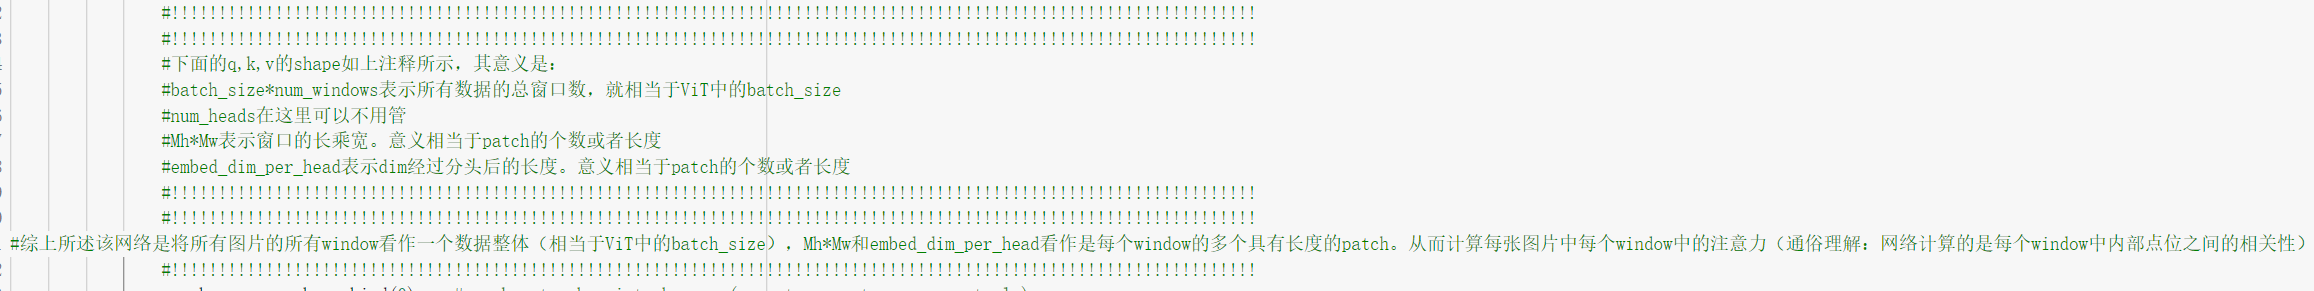

In [112]:
import torch.nn.functional as F
class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.
    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # [Mh, Mw]
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # [2*Mh-1 * 2*Mw-1, nH] 每个head都有一个table

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w], indexing="ij"))  # [2, Mh, Mw]
        coords_flatten = torch.flatten(coords, 1)  # [2, Mh*Mw]
        # [2, Mh*Mw, 1] - [2, 1, Mh*Mw]
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # [2, Mh*Mw, Mh*Mw]
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # [Mh*Mw, Mh*Mw, 2]  这里的2表示一项行标一项列标
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0    在行标上加上（windowsize-1）
        relative_coords[:, :, 1] += self.window_size[1] - 1  #    在列标上加上（windowsize-1）
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1#    在列标上乘两倍windowsize再减一
        relative_position_index = relative_coords.sum(-1)  # [Mh*Mw, Mh*Mw]  行标加上列标
        self.register_buffer("relative_position_index", relative_position_index)#将固定的index放进模型缓存中（不需要修改）

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        nn.init.trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

        self.temperature = nn.Parameter(torch.ones(num_heads, 1, 1))

    def forward(self, x, mask: Optional[torch.Tensor] = None):
        """
        Args:
            x: input features with shape of (num_windows*B, Mh*Mw, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        print("***************************WindowAttention Start********************************")
        print("输入数据：x.shape:{}".format(str(x.shape)))
        #print("输入数据：x.shape:{} | mask.shape:{}".format(str(x.shape),str(mask.shape)))
        # [batch_size*num_windows, Mh*Mw, total_embed_dim]
        B_, N, C = x.shape
        # qkv(): -> [batch_size*num_windows, Mh*Mw, 3 * total_embed_dim]
        # reshape: -> [batch_size*num_windows, Mh*Mw, 3, num_heads, embed_dim_per_head]
        # permute: -> [3, batch_size*num_windows, num_heads, Mh*Mw, embed_dim_per_head]
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        # [batch_size*num_windows, num_heads, Mh*Mw, embed_dim_per_head]
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        #下面的q,k,v的shape如上注释所示，其意义是：
        #batch_size*num_windows表示所有数据的总窗口数，就相当于ViT中的batch_size
        #num_heads在这里可以不用管
        #Mh*Mw表示窗口的长乘宽。意义相当于patch的个数或者长度
        #embed_dim_per_head表示dim经过分头后的长度。意义相当于patch的个数或者长度
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        #综上所述该网络是将所有图片的所有window看作一个数据整体（相当于ViT中的batch_size），Mh*Mw和embed_dim_per_head看作是每个window的多个具有长度的patch。从而计算每张图片中每个window中的注意力（通俗理解：网络计算的是每个window中内部点位之间的相关性）
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        q, k, v = qkv.unbind(0)  # make torchscript happy (cannot use tensor as tuple)
        print("WindowAttention______q.shape:{} |k.shape:{} |v.shape:{}".format(str(q.shape),str(k.shape),str(v.shape)))

        #****************************ChannelAttention**************************
        #q_c, k_c, v_c = qkv[0], qkv[1], qkv[2]

        #q_c = q_c.transpose(-2, -1)
        #k_c = k_c.transpose(-2, -1)
        #v_c = v_c.transpose(-2, -1)

        #q_c = F.normalize(q_c, dim=-1)
        #k_c = F.normalize(k_c, dim=-1)

        #attn_c = (q_c @ k_c.transpose(-2, -1)) * self.temperature
        #attn_c = attn_c.softmax(dim=-1)
        #attn_c = self.attn_drop(attn_c)
        #x_c = (attn_c @ v_c).permute(0, 3, 1, 2).reshape(B_, N, C)
        #x_c = self.proj(x_c)
        #x_c = self.proj_drop(x_c)
        #****************************ChannelAttention had down**************************

        # transpose: -> [batch_size*num_windows, num_heads, embed_dim_per_head, Mh*Mw]
        # @: multiply -> [batch_size*num_windows, num_heads, Mh*Mw, Mh*Mw]
        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))
        print("WindowAttention______attn of q&k shape:",attn.shape)

        # relative_position_bias_table.view: [Mh*Mw*Mh*Mw,nH] -> [Mh*Mw,Mh*Mw,nH]
        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # [nH, Mh*Mw, Mh*Mw]
        print("WindowAttention______相对位置偏移relative_position_bias.shape:",relative_position_bias.shape)
        attn = attn + relative_position_bias.unsqueeze(0)
        print("WindowAttention______attn加上相对位置偏移后的attn.shape:",attn.shape)

        if mask is not None:
            print("WindowAttention______S-WMSA")
            print("mask.shape:",mask.shape)
            # mask: [nW, Mh*Mw, Mh*Mw]
            nW = mask.shape[0]  # num_windows
            # attn.view: [batch_size, num_windows, num_heads, Mh*Mw, Mh*Mw]
            # mask.unsqueeze: [1, nW, 1, Mh*Mw, Mh*Mw]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N)
            print("WindowAttention______view之后的attn.shape:",attn.shape)
            mask_un = mask.unsqueeze(1).unsqueeze(0)
            print("WindowAttention______unsqueeze之后的mask.shape:",mask_un.shape)
            attn = attn + mask_un
            print("WindowAttention______(attn+mask).shape:",attn.shape)
            attn = attn.view(-1, self.num_heads, N, N)
            print("WindowAttention______view之后的(attn+mask).shape:",attn.shape)
            attn = self.softmax(attn)
        else:
            print("WindowAttention______WMSA")
            attn = self.softmax(attn)
        print("WindowAttention______输入数据加上mask后的attn.shape:",attn.shape)
        attn = self.attn_drop(attn)

        # @: multiply -> [batch_size*num_windows, num_heads, Mh*Mw, embed_dim_per_head]
        # transpose: -> [batch_size*num_windows, Mh*Mw, num_heads, embed_dim_per_head]
        # reshape: -> [batch_size*num_windows, Mh*Mw, total_embed_dim]
        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        print("WindowAttention______after attn&v x.shape:",x.shape)
        x = self.proj(x)
        x = self.proj_drop(x)
        print("WindowAttention______维度操作后的x.shape:",x.shape)
        print("WindowAttention______注意力计算完成后的x.shape:",x.shape)
        #print("通道注意力计算完成后的x_c.shape:",x_c.shape)
        #x = x + x_c
        print("***************************WindowAttention Finish********************************")
        return x

In [113]:
coords_h = torch.arange(4)
coords_w = torch.arange(4)
coords = torch.stack(torch.meshgrid([coords_h, coords_w], indexing="ij"))
print("coords_h.shape",coords_h.shape)
print(coords_h)
print("coords_w.shape",coords_w.shape)
print(coords_w)
print("coords.shape",coords.shape)
print(coords)

coords_flatten = torch.flatten(coords, 1)
print("coords_flatten.shape",coords_flatten.shape)
print(coords_flatten)

relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
print("relative_coords.shape",relative_coords.shape)
print(relative_coords)
print("变换顺序")
relative_coords = relative_coords.permute(1, 2, 0).contiguous()
print("relative_coords.shape",relative_coords.shape)
#print(relative_coords)
relative_coords[:, :, 0] += 4 - 1  # shift to start from 0
relative_coords[:, :, 1] += 4 - 1
relative_coords[:, :, 0] *= 2 * 4 - 1
relative_position_index = relative_coords.sum(-1)  # [Mh*Mw, Mh*Mw]
print("relative_position_index.shape",relative_position_index.shape)
print(relative_position_index)

coords_h.shape torch.Size([4])
tensor([0, 1, 2, 3])
coords_w.shape torch.Size([4])
tensor([0, 1, 2, 3])
coords.shape torch.Size([2, 4, 4])
tensor([[[0, 0, 0, 0],
         [1, 1, 1, 1],
         [2, 2, 2, 2],
         [3, 3, 3, 3]],

        [[0, 1, 2, 3],
         [0, 1, 2, 3],
         [0, 1, 2, 3],
         [0, 1, 2, 3]]])
coords_flatten.shape torch.Size([2, 16])
tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3],
        [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]])
relative_coords.shape torch.Size([2, 16, 16])
tensor([[[ 0,  0,  0,  0, -1, -1, -1, -1, -2, -2, -2, -2, -3, -3, -3, -3],
         [ 0,  0,  0,  0, -1, -1, -1, -1, -2, -2, -2, -2, -3, -3, -3, -3],
         [ 0,  0,  0,  0, -1, -1, -1, -1, -2, -2, -2, -2, -3, -3, -3, -3],
         [ 0,  0,  0,  0, -1, -1, -1, -1, -2, -2, -2, -2, -3, -3, -3, -3],
         [ 1,  1,  1,  1,  0,  0,  0,  0, -1, -1, -1, -1, -2, -2, -2, -2],
         [ 1,  1,  1,  1,  0,  0,  0,  0, -1, -1, -1, -1, -2, -2, -2, -2],
         [ 1,  1,  

In [114]:
class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.
    Args:
        dim (int): Number of input channels.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=(self.window_size, self.window_size), num_heads=num_heads, qkv_bias=qkv_bias,
            attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, attn_mask):
        print("---单体block开始运行---")
        print("输入数据：x.shape:{} | mask.shape:{}".format(str(x.shape),str(attn_mask.shape)))
        H, W = self.H, self.W
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)
        print("SwinTransformerBlock___after view x.shape:",x.shape)

        # pad feature maps to multiples of window size
        # 把feature map给pad到window size的整数倍
        pad_l = pad_t = 0
        pad_r = (self.window_size - W % self.window_size) % self.window_size
        pad_b = (self.window_size - H % self.window_size) % self.window_size
        x = F.pad(x, (0, 0, pad_l, pad_r, pad_t, pad_b))
        _, Hp, Wp, _ = x.shape
        print("SwinTransformerBlock.....pad之后的数据x.shape:",x.shape)

        # cyclic shift
        #先将数据的的位置变换了，再取窗口。此处就是将数据的位置变了
        print("shift_size:",self.shift_size)
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x
            attn_mask = None

        # partition windows
        print("SwinTransformerBlock.....进行窗口划分前的数据x.shape:",x.shape)
        x_windows = window_partition(shifted_x, self.window_size)  # [nW*B, Mh, Mw, C]
        print("SwinTransformerBlock.....将数据按窗口划分，划分后的数据shape为：",x_windows.shape)
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # [nW*B, Mh*Mw, C]
        print("SwinTransformerBlock.....将窗口数据view，变形后的数据shape为：",x_windows.shape)

        # W-MSA/SW-MSA
        print("SwinTransformerBlock.....开始计算注意力(W-MSA/SW-MSA).....")
        attn_windows = self.attn(x_windows, mask=attn_mask)  # [nW*B, Mh*Mw, C]
        
        print("SwinTransformerBlock.....注意力计算完成！此时数据的attn_windows.shape为：",attn_windows.shape)

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)  # [nW*B, Mh, Mw, C]
        print("SwinTransformerBlock.....将注意力计算完成的数据再view，此时数据的shape为：",attn_windows.shape)
        shifted_x = window_reverse(attn_windows, self.window_size, Hp, Wp)  # [B, H', W', C]
        print("SwinTransformerBlock.....对数据进行逆窗口变换，变换后数据的shifted_x.shape为：",shifted_x.shape)

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x

        if pad_r > 0 or pad_b > 0:
            # 把前面pad的数据移除掉
            x = x[:, :H, :W, :].contiguous()
        print("SwinTransformerBlock.....逆pad之后的数据x.shape:",x.shape)

        x = x.view(B, H * W, C)
        print("SwinTransformerBlock.....view之后的数据x.shape:",x.shape)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        print("一个SwinTransformerBlock处理完成后(attention+mlp)的数据x.shape:",x.shape)
        print("_"*100)

        return x


In [115]:
box1 = torch.randn(6,6)
print(box1)
shifted_box1 = torch.roll(box1, shifts=(-2, -2), dims=(0, 1))
print(shifted_box1)

tensor([[-2.1956, -0.6827,  0.3186, -1.4608,  1.4620,  0.5546],
        [ 0.2107, -0.4224,  0.2838,  0.2016,  1.4952, -1.7346],
        [-0.6767,  1.5341, -0.0194,  1.7277,  0.4998, -0.4292],
        [-0.4373,  1.4568, -0.7676,  1.3222, -0.1713,  0.7331],
        [-0.0341,  0.9429, -0.5517, -0.1040,  0.5773, -0.1775],
        [ 0.3946,  0.2761,  0.3342,  1.2395, -0.0435, -1.1930]])
tensor([[-0.0194,  1.7277,  0.4998, -0.4292, -0.6767,  1.5341],
        [-0.7676,  1.3222, -0.1713,  0.7331, -0.4373,  1.4568],
        [-0.5517, -0.1040,  0.5773, -0.1775, -0.0341,  0.9429],
        [ 0.3342,  1.2395, -0.0435, -1.1930,  0.3946,  0.2761],
        [ 0.3186, -1.4608,  1.4620,  0.5546, -2.1956, -0.6827],
        [ 0.2838,  0.2016,  1.4952, -1.7346,  0.2107, -0.4224]])


In [116]:
!pip install xlwt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [117]:
import xlwt
class BasicLayer(nn.Module):
    """
    A basic Swin Transformer layer for one stage.
    Args:
        dim (int): Number of input channels.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):
        super().__init__()
        self.dim = dim
        self.depth = depth
        self.window_size = window_size
        self.use_checkpoint = use_checkpoint
        self.shift_size = window_size // 2

        # build blocks
        self.blocks = nn.ModuleList([
            # 每一个block都包含一个WMSA和一个SWMSA
            SwinTransformerBlock(
                dim=dim,
                num_heads=num_heads,
                window_size=window_size,
                shift_size=0 if (i % 2 == 0) else self.shift_size,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                drop=drop,
                attn_drop=attn_drop,
                drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def create_mask(self, x, H, W):
        # calculate attention mask for SW-MSA
        # 保证Hp和Wp是window_size的整数倍
        print("create_mask_________x.shape:{} | H:{} | W:{}".format(str(x.shape),int(H),int(W)))
        Hp = int(np.ceil(H / self.window_size)) * self.window_size
        Wp = int(np.ceil(W / self.window_size)) * self.window_size
        # 拥有和feature map一样的通道排列顺序，方便后续window_partition
        img_mask = torch.zeros((1, Hp, Wp, 1), device=x.device)  # [1, Hp, Wp, 1]
        print("create_mask_________img_mask.shape:",img_mask.shape)
        h_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        w_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        cnt = 0
        #print(h_slices)
        #print(w_slices)
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1
        #print(img_mask)
        img_mask_bf = img_mask
        img_mask_bf = img_mask_bf.squeeze(0).squeeze(-1)
        #print(img_mask_bf)
        if Hp == 56:
          img_mask_bf_np = img_mask_bf.numpy()
          np.save('img_mask_bf_np', img_mask_bf_np)

        #将mask进行窗口划分
        mask_windows = window_partition(img_mask, self.window_size)  # [nW, Mh, Mw, 1]
        print("create_mask_________afetr window_partition mask_windows.shape:",mask_windows.shape)
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)  # [nW, Mh*Mw]
        print("create_mask_________after view mask_windows.shape:",mask_windows.shape)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)  # [nW, 1, Mh*Mw] - [nW, Mh*Mw, 1]
        print("create_mask_________after unsqueeze mask_windows.shape:",mask_windows.shape)
        # [nW, Mh*Mw, Mh*Mw]
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        return attn_mask

    def forward(self, x, H, W):
        print("开始创建mask...")
        attn_mask = self.create_mask(x, H, W)  # [nW, Mh*Mw, Mh*Mw]
        print("创建attn_mask，attn_mask.shape:",attn_mask.shape)
        th_blk=0
        for blk in self.blocks:
            blk.H, blk.W = H, W
            print("第 {} block开始运行".format(th_blk))
            if not torch.jit.is_scripting() and self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x, attn_mask)
            else:
                x = blk(x, attn_mask)
            print("第 {} block 运行完成，输出结果x.shape:{}".format(th_blk,str(x.shape)))
            th_blk+=1
        if self.downsample is not None:
            x = self.downsample(x, H, W)
            H, W = (H + 1) // 2, (W + 1) // 2
            print("PatchMerging运行完成，输出数据：x.shape:{},H:{},W:{}".format(str(x.shape),H,W))

        return x, H, W

In [118]:
class SwinTransformer(nn.Module):
    r""" Swin Transformer
        A PyTorch impl of : `Swin Transformer: Hierarchical Vision Transformer using Shifted Windows`  -
          https://arxiv.org/pdf/2103.14030
    Args:
        patch_size (int | tuple(int)): Patch size. Default: 4
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
    """

    def __init__(self, patch_size=4, in_chans=3, num_classes=10,
                 embed_dim=96, depths=(2, 2, 6, 2), num_heads=(3, 6, 12, 24),
                 window_size=7, mlp_ratio=4., qkv_bias=True,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, patch_norm=True,
                 use_checkpoint=False, **kwargs):
        super().__init__()

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.patch_norm = patch_norm
        # stage4输出特征矩阵的channels
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            patch_size=patch_size, in_c=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            # 注意这里构建的stage和论文图中有些差异
            # 这里的stage不包含该stage的patch_merging层，包含的是下个stage的.
            layers = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                                depth=depths[i_layer],
                                num_heads=num_heads[i_layer],
                                window_size=window_size,
                                mlp_ratio=self.mlp_ratio,
                                qkv_bias=qkv_bias,
                                drop=drop_rate,
                                attn_drop=attn_drop_rate,
                                drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                                norm_layer=norm_layer,
                                downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                                use_checkpoint=use_checkpoint)
            self.layers.append(layers)

        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        
        #
        print("*"*100)
        print("Start")
        print("*"*100)
        print("输入的数据x.shape:",x.shape)
        x, H, W = self.patch_embed(x)
        print("PatchEmbed.....patch_embeding之后的数据x.shape为：",x.shape)
        x = self.pos_drop(x)
        print("PatchEmbed.....pos_drop之后的数据x.shape为：",x.shape)
        # x: [B, L, C]
        print("*"*100)

        print(".....From Stage1 to Stage4.....")
        print("*"*100)
        th_layer = 0
        for layer in self.layers:
            print("Stage {} 开始运行".format(int(th_layer)))
            print("输出数据：x.shape:{},H:{},W:{}".format(str(x.shape),H,W))
            x, H, W = layer(x, H, W)
            th_layer += 1
            print("Stage {} 运行完成--输出结果：x.shape:{},H:{},W:{}".format(int(th_layer),str(x.shape),H,W))
        print("The Stage1 to Stage4 Has Finish")
        print("*"*100)

        print("此时x.shape:",x.shape)
        x = self.norm(x)  # [B, L, C]
        print("after norm x.shape:",x.shape)
        x = self.avgpool(x.transpose(1, 2))  # [B, C, 1]
        print("after avgpool x.shape:",x.shape)
        x = torch.flatten(x, 1)
        print("after flatten x.shape:",x.shape)
        x = self.head(x)
        print("final output x.shape:",x.shape)
        return x

In [119]:
a1 = torch.rand(1,3,224,224)
net = SwinTransformer()
a2 = net(a1)


****************************************************************************************************
Start
****************************************************************************************************
输入的数据x.shape: torch.Size([1, 3, 224, 224])
PatchEmbed.....初步卷积后的数据shape为： torch.Size([1, 96, 56, 56])
PatchEmbed.....patch_embeding之后的数据x.shape为： torch.Size([1, 3136, 96])
PatchEmbed.....pos_drop之后的数据x.shape为： torch.Size([1, 3136, 96])
****************************************************************************************************
.....From Stage1 to Stage4.....
****************************************************************************************************
Stage 0 开始运行
输出数据：x.shape:torch.Size([1, 3136, 96]),H:56,W:56
开始创建mask...
create_mask_________x.shape:torch.Size([1, 3136, 96]) | H:56 | W:56
create_mask_________img_mask.shape: torch.Size([1, 56, 56, 1])
create_mask_________afetr window_partition mask_windows.shape: torch.Size([64, 7, 7, 1])
create_mask_________after vi

In [121]:
a1 = torch.rand(1,30,21,21)
net = SwinTransformer(in_chans=30)
a2 = net(a1)


****************************************************************************************************
Start
****************************************************************************************************
输入的数据x.shape: torch.Size([1, 30, 21, 21])
PatchEmbed.....初步卷积后的数据shape为： torch.Size([1, 96, 6, 6])
PatchEmbed.....patch_embeding之后的数据x.shape为： torch.Size([1, 36, 96])
PatchEmbed.....pos_drop之后的数据x.shape为： torch.Size([1, 36, 96])
****************************************************************************************************
.....From Stage1 to Stage4.....
****************************************************************************************************
Stage 0 开始运行
输出数据：x.shape:torch.Size([1, 36, 96]),H:6,W:6
开始创建mask...
create_mask_________x.shape:torch.Size([1, 36, 96]) | H:6 | W:6
create_mask_________img_mask.shape: torch.Size([1, 7, 7, 1])
create_mask_________afetr window_partition mask_windows.shape: torch.Size([1, 7, 7, 1])
create_mask_________after view mask_windows.sh